# RNN的Pytorch API使用以及手动实现RNN Forward函数
- 这里实现了三种情况：
    - 单向、单层的RNN
    - 单向、双层的RNN
    - 双向、单层的RNN
- 如果是双向，那么这两层的输入都是一样的（比如对于第一层来说，输入都是x），只不过顺序要反转一下，可以使用`torch.flip()`
- 如果是多层，那么上面层的输入是下面层的输出


- RNN Forward公式：
    - ![CleanShot 2024-08-01 at 17.19.23@2x.png](<attachment:CleanShot 2024-08-01 at 17.19.23@2x.png>)
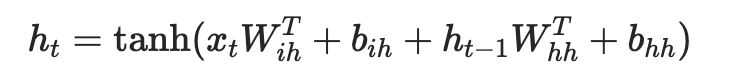

## 包导入和参数设置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

batch_size, seq_len = 2, 3  # 批大小, 输入序列长度
input_size, hidden_size = 2, 3  # 输入特征大小feature, 隐藏层大小
input = torch.randn(batch_size, seq_len, input_size)  # 随机初始化一个特征序列
h_prev = torch.zeros(batch_size, hidden_size)  # 初始隐含状态


## 单向、单层

In [2]:
# 单向、单层RNN Pytorch API
rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=1)  # number_layers默认为1
output, h_n = rnn(input, h_prev.unsqueeze(0))  # h_prev: [num_layers, b, hidden_size]

print(output.shape)  # [2,3,3] [batch_size, seq_len, hidden_size]
print(h_n.shape)  # [1,2,3] [D*num_layers, batch_size, hidden_size]


torch.Size([2, 3, 3])
torch.Size([1, 2, 3])


In [3]:
for name, para in rnn.named_parameters():
    print(name, para.shape)


weight_ih_l0 torch.Size([3, 2])
weight_hh_l0 torch.Size([3, 3])
bias_ih_l0 torch.Size([3])
bias_hh_l0 torch.Size([3])


In [4]:
def rnn_forward(input, weight_ih, weight_hh, bias_ih, bias_hh, h_prev):
    batch_size, seq_len, input_size = input.shape
    hidden_size = h_prev.shape[-1]
    output = torch.zeros(batch_size, seq_len, hidden_size)  # 初始化一个输出（状态）矩阵

    for t in range(seq_len):  # RNN的计算复杂度是与序列长度呈线性相关的
        #-------------------实现 1------------------
        # x = input[:, t, :].unsqueeze(1)  # 获取当前时刻输入特征， [b, input_size] -> [b, 1, input_size]
        # w_ih_batch = weight_ih.unsqueeze(0).tile(batch_size, 1, 1)  # [b, hidden_size, input_size]
        # w_hh_batch = weight_hh.unsqueeze(0).tile(batch_size, 1, 1)  # [b, hidden_size, hidden_size]

        # w_times_x = torch.bmm(x, w_ih_batch.transpose(1, 2)).squeeze(1)  # 含有batch批大小的矩阵相乘
        # # [b, 1, input_size] * [b, input_size, hidden_size] -> [b, 1, hidden_size] -> [b, hidden_size]
        # w_times_h = torch.bmm(h_prev.unsqueeze(1), w_hh_batch.transpose(1, 2)).squeeze(1)
        # # [b, 1, hidden_size] * [b, hidden_size, hidden_size] -> [b, 1, hidden_size] -> [b, hidden_size]
        # h_prev = torch.tanh(w_times_x + bias_ih + w_times_h + bias_hh)  # [b, hidden]  bias相加的时候使用了广播机制
        # output[:, t, :] = h_prev
        #-------------------实现 2------------------
        x = input[:, t, :]
        w_times_x = x @ weight_ih.T
        w_times_h = h_prev @ weight_hh.T
        h_prev = torch.tanh(w_times_x + bias_ih + w_times_h + bias_hh)    # [b, hidden]  bias相加的时候使用了广播机制
        output[:, t, :] = h_prev
        
    return output, h_prev.unsqueeze(0)  # 官方是三维，在第0维扩一维


In [5]:
# 这里使用 rnn 中的参数
# 加了me表示自己手写的
output_me, h_n_me = rnn_forward(input, rnn.weight_ih_l0, rnn.weight_hh_l0,
                                rnn.bias_ih_l0, rnn.bias_hh_l0, h_prev)


In [6]:
print("PyTorch API output:")
print(output)  # [2,3,3] [batch_size, seq_len, hidden_size]
print(h_n)  # [1,2,3] [num_layers, batch_size, hidden_size]
print("\nrnn_forward function output:")
print(output_me)  # [2, 3, 3]
print(h_n_me)  # [1, 2, 3]


PyTorch API output:
tensor([[[-0.1809, -0.2195,  0.6097],
         [ 0.6241,  0.2887,  0.6759],
         [-0.6642,  0.0170, -0.0428]],

        [[-0.6516, -0.4708,  0.3410],
         [ 0.5613, -0.4842,  0.8286],
         [ 0.8614,  0.4550,  0.7472]]], grad_fn=<TransposeBackward1>)
tensor([[[-0.6642,  0.0170, -0.0428],
         [ 0.8614,  0.4550,  0.7472]]], grad_fn=<StackBackward0>)

rnn_forward function output:
tensor([[[-0.1809, -0.2195,  0.6097],
         [ 0.6241,  0.2887,  0.6759],
         [-0.6642,  0.0170, -0.0428]],

        [[-0.6516, -0.4708,  0.3410],
         [ 0.5613, -0.4842,  0.8286],
         [ 0.8614,  0.4550,  0.7472]]], grad_fn=<CopySlices>)
tensor([[[-0.6642,  0.0170, -0.0428],
         [ 0.8614,  0.4550,  0.7472]]], grad_fn=<UnsqueezeBackward0>)


## 单向、双层

In [7]:
# 单向、双层RNN Pytorch API
rnn_2layer = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=2)  # number_layers默认为1
h_prev_2layer = torch.zeros(2, batch_size, hidden_size)  # 初始隐含状态
output_2layer, h_n_2layer = rnn_2layer(input, h_prev_2layer)  # h_prev: [num_layers, b, hidden_size]

print(output_2layer.shape)  # [2,3,3] [batch_size, seq_len, hidden_size]
print(h_n_2layer.shape)  # [1,2,3] [D*num_layers, batch_size, hidden_size]


torch.Size([2, 3, 3])
torch.Size([2, 2, 3])


In [8]:
for name, para in rnn_2layer.named_parameters():
    print(name, para.shape)

weight_ih_l0 torch.Size([3, 2])
weight_hh_l0 torch.Size([3, 3])
bias_ih_l0 torch.Size([3])
bias_hh_l0 torch.Size([3])
weight_ih_l1 torch.Size([3, 3])
weight_hh_l1 torch.Size([3, 3])
bias_ih_l1 torch.Size([3])
bias_hh_l1 torch.Size([3])


In [9]:
output1_me_2layer, h1_n_me_2layer = rnn_forward(input, rnn_2layer.weight_ih_l0, rnn_2layer.weight_hh_l0,
                                rnn_2layer.bias_ih_l0, rnn_2layer.bias_hh_l0, h_prev_2layer[0])

output2_me_2layer, h2_n_me_2layer = rnn_forward(output1_me_2layer, rnn_2layer.weight_ih_l1, rnn_2layer.weight_hh_l1,
                                rnn_2layer.bias_ih_l1, rnn_2layer.bias_hh_l1, h_prev_2layer[1])
output_me_2layer = output2_me_2layer
h_n_me_2layer = torch.concat((h1_n_me_2layer, h2_n_me_2layer), dim=0)

In [10]:
print("PyTorch API output:")
print(output_2layer)  # [2,3,3] [batch_size, seq_len, hidden_size]
print(h_n_2layer)  # [1,2,3] [num_layers, batch_size, hidden_size]
print("\nrnn_forward function output:")
print(output_me_2layer)  # [2, 3, 3]
print(h_n_me_2layer)  # [1, 2, 3]

PyTorch API output:
tensor([[[ 0.1927,  0.1880,  0.7041],
         [ 0.1093,  0.5192,  0.6723],
         [-0.1558,  0.4954,  0.5601]],

        [[-0.0698,  0.1778,  0.6435],
         [-0.1151,  0.4738,  0.5220],
         [ 0.5878,  0.5104,  0.6434]]], grad_fn=<TransposeBackward1>)
tensor([[[ 0.2120,  0.7518,  0.9251],
         [ 0.9036, -0.5829,  0.1611]],

        [[-0.1558,  0.4954,  0.5601],
         [ 0.5878,  0.5104,  0.6434]]], grad_fn=<StackBackward0>)

rnn_forward function output:
tensor([[[ 0.1927,  0.1880,  0.7041],
         [ 0.1093,  0.5192,  0.6723],
         [-0.1558,  0.4954,  0.5601]],

        [[-0.0698,  0.1778,  0.6435],
         [-0.1151,  0.4738,  0.5220],
         [ 0.5878,  0.5104,  0.6434]]], grad_fn=<CopySlices>)
tensor([[[ 0.2120,  0.7518,  0.9251],
         [ 0.9036, -0.5829,  0.1611]],

        [[-0.1558,  0.4954,  0.5601],
         [ 0.5878,  0.5104,  0.6434]]], grad_fn=<CatBackward0>)


## 双向、单层

In [11]:
# 双向、单层RNN Pytorch API
bi_rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)  # number_layers默认为1
h_prev = torch.zeros(2, batch_size, hidden_size)  # 初始隐含状态
bi_output, bi_h_n = bi_rnn(input, h_prev)  # h_prev: [D*num_layers, b, hidden_size]
for name, para in bi_rnn.named_parameters():
    print(name, "\t", para.shape)


weight_ih_l0 	 torch.Size([3, 2])
weight_hh_l0 	 torch.Size([3, 3])
bias_ih_l0 	 torch.Size([3])
bias_hh_l0 	 torch.Size([3])
weight_ih_l0_reverse 	 torch.Size([3, 2])
weight_hh_l0_reverse 	 torch.Size([3, 3])
bias_ih_l0_reverse 	 torch.Size([3])
bias_hh_l0_reverse 	 torch.Size([3])


In [12]:
def bidirectional_rnn_forward(input, weight_ih, weight_hh, bias_ih, bias_hh, h_prev,
                              weight_ih_reverse, weight_hh_reverse, bias_ih_reverse, bias_hh_reverse, h_prev_reverse):
    batch_size, seq_len, input_size = input.shape
    hidden_size = h_prev.shape[-1]  # 这里只能用方括号
    output = torch.zeros(batch_size, seq_len, hidden_size * 2)  # 初始化一个输出（状态）矩阵 [b,seq_len,D*hidden_size]
    # 注意双向是两倍的 hidden_size

    forward_out, _ =rnn_forward(input, weight_ih, weight_hh, bias_ih, bias_hh, h_prev)  # forward layer
    backward_out, _ = rnn_forward(torch.flip(input, [1]), weight_ih_reverse, weight_hh_reverse,
                                  bias_ih_reverse, bias_hh_reverse, h_prev_reverse)
    # backward layer 反向的时候需要将 input 在 seq_len 这一维进行翻转
    output[:, :, :hidden_size] = forward_out
    output[:, :, hidden_size:] = torch.flip(backward_out, [1])

    h_n = torch.zeros(batch_size, 2, hidden_size)
    h_n[:, 0, :] = forward_out[:, -1, :]  # forward_out中最后一个seq的状态
    h_n[:, 1, :] = backward_out[:, -1, :]  # backward_out中最后一个seq的状态
    return output, h_n.transpose(0, 1)  # 转换为[num_layers, b, hidden_size]


In [13]:
bi_output_me, bi_h_n_me = bidirectional_rnn_forward(input, bi_rnn.weight_ih_l0,
                                                    bi_rnn.weight_hh_l0, bi_rnn.bias_ih_l0,
                                                    bi_rnn.bias_hh_l0, h_prev[0],
                                                    bi_rnn.weight_ih_l0_reverse,
                                                    bi_rnn.weight_hh_l0_reverse,
                                                    bi_rnn.bias_ih_l0_reverse,
                                                    bi_rnn.bias_hh_l0_reverse, h_prev[1])
# 这里注意一下h_prev的维度[2,b,hidden_size]，h_prev[0]是[b, hidden_size],与传入rnn_forward的维度保持一致

print("PyTorch API output:")
print(bi_output)  # [2,3,6] [b, seq_len, D*hidden_size]
print(bi_h_n)  # [2,2,3] [D*num_layers, b, hidden_size]
print("\nbidirectional_rnn_forward function output:")
print(bi_output_me)  # [2,3,6]
print(bi_h_n_me)  # [2,2,3]


PyTorch API output:
tensor([[[ 0.5409,  0.6234, -0.1404, -0.0441,  0.1104,  0.9436],
         [-0.2243,  0.7065,  0.4948, -0.7582,  0.7586,  0.7575],
         [ 0.6775,  0.0336, -0.5918, -0.0537,  0.0134,  0.9066]],

        [[ 0.8411,  0.2166, -0.6354,  0.3184, -0.2873,  0.9147],
         [ 0.5560,  0.8209, -0.0963,  0.0167,  0.2557,  0.9205],
         [-0.5991,  0.9558,  0.7247, -0.8570,  0.9307,  0.3098]]],
       grad_fn=<TransposeBackward1>)
tensor([[[ 0.6775,  0.0336, -0.5918],
         [-0.5991,  0.9558,  0.7247]],

        [[-0.0441,  0.1104,  0.9436],
         [ 0.3184, -0.2873,  0.9147]]], grad_fn=<StackBackward0>)

bidirectional_rnn_forward function output:
tensor([[[ 0.5409,  0.6234, -0.1404, -0.0441,  0.1104,  0.9436],
         [-0.2243,  0.7065,  0.4948, -0.7582,  0.7586,  0.7575],
         [ 0.6775,  0.0336, -0.5918, -0.0537,  0.0134,  0.9066]],

        [[ 0.8411,  0.2166, -0.6354,  0.3184, -0.2873,  0.9147],
         [ 0.5560,  0.8209, -0.0963,  0.0167,  0.2557,  0.920